In [1]:
import pandas as pd
import scipy
from scipy import stats 
import seaborn as sns
from scipy.stats import levene
import numpy as np
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, 
   MultiComparison)
from statsmodels.formula.api import ols 
from statsmodels.stats.anova import anova_lm 

sns.set(rc={'figure.figsize': (12,6)}, style="whitegrid")

Загрузим данные для первого теста, где использовались фотографии блюд в трёх разных разрешениях.

In [2]:
df_test_1 = pd.read_csv('C:/Users/Валерия/Downloads/test_1.csv')

Чтобы проверить, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена, поместим необходимые данные в массивы.

In [3]:
A = df_test_1[df_test_1['group'] == "A"]['events'].to_numpy()

In [4]:
B = df_test_1[df_test_1['group'] == "B"]['events'].to_numpy()

In [5]:
C = df_test_1[df_test_1['group'] == "C"]['events'].to_numpy()

In [6]:
scipy.stats.levene(A, B, C)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

Убедимся, что данные распределены нормально, применив тест Шапиро-Уилка. Перед применением критерия при проверке на нормальность сделаем семплирование (1000 наблюдений), так как на больших выборках могут получаться неверные результаты.

In [7]:
stats.shapiro(df_test_1[df_test_1['group'] == "A"]['events'].sample(1000, random_state=17))

ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)

In [8]:
stats.shapiro(df_test_1[df_test_1['group'] == "B"]['events'].sample(1000, random_state=17))

ShapiroResult(statistic=0.9980798363685608, pvalue=0.31768906116485596)

In [9]:
stats.shapiro(df_test_1[df_test_1['group'] == "C"]['events'].sample(1000, random_state=17))

ShapiroResult(statistic=0.9981185793876648, pvalue=0.3359004259109497)

Для сравнения средних используем однофакторный дисперсионный анализ (f_oneway).

In [10]:
scipy.stats.f_oneway(A, B, C)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

In [11]:
round(scipy.stats.f_oneway(A, B, C)[0])

2886

С помощью критерия Тьюки проверим, есть ли статистически значимые различия и между какими группами.

In [12]:
print(pairwise_tukeyhsd(df_test_1['events'], groups=df_test_1['group']).summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034 0.001   7.7038  8.3642   True
     A      C  -2.1093 0.001  -2.4395 -1.7791   True
     B      C -10.1433 0.001 -10.4735 -9.8131   True
----------------------------------------------------


Считаем данные второго теста, где было представлено изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

In [13]:
df_test_2 = pd.read_csv('C:/Users/Валерия/Downloads/test_2.csv')

Визуализируем распределение events для контрольной и тестовой групп.

D:\jupiter\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='events'>

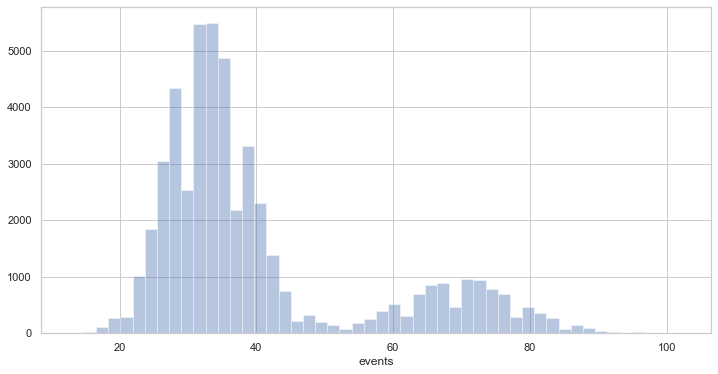

In [14]:
sns.distplot(df_test_2.query('group == "test"').events, kde=False)

<AxesSubplot:xlabel='events'>

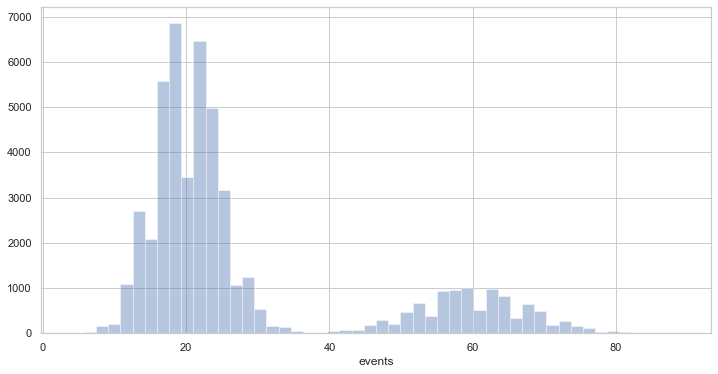

In [15]:
sns.distplot(df_test_2.query('group == "control"').events, kde=False)

Посмотрим среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. 

In [16]:
df_test_2.groupby(['group', 'segment']).events.describe().T

group         control                        test              
segment          high           low          high           low
count    10000.000000  40000.000000  10000.000000  40000.000000
mean        59.970800     20.031575     69.938500     33.025925
std          7.805347      4.473576      8.403974      5.720845
min         31.000000      4.000000     40.000000     13.000000
25%         55.000000     17.000000     64.000000     29.000000
50%         60.000000     20.000000     70.000000     33.000000
75%         65.000000     23.000000     76.000000     37.000000
max         89.000000     41.000000    102.000000     59.000000

Проведём тест через anova_lm.

In [17]:
formula = 'events ~ segment + group + segment:group' 

model = ols(formula, df_test_2).fit() 
aov_table = anova_lm(model, typ=2) 

aov_table

,sum_sq,df,F,PR(>F)
segment,2.362480e+07,1.0,689756.377486,0.000000e+00
group,3.837195e+06,1.0,112031.864120,0.000000e+00
segment:group,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


Перед использованием критерия Тьюки соединим колонки group и segment в combination.

In [18]:
combination = df_test_2['group'] + ' \ ' + df_test_2['segment']

In [19]:
print(pairwise_tukeyhsd(df_test_2['events'], groups=combination).summary())

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2    meandiff p-adj  lower    upper   reject
--------------------------------------------------------------------
control \ high control \ low -39.9392 0.001 -40.1073 -39.7711   True
control \ high   test \ high   9.9677 0.001   9.7551  10.1803   True
control \ high    test \ low -26.9449 0.001  -27.113 -26.7768   True
 control \ low   test \ high  49.9069 0.001  49.7388   50.075   True
 control \ low    test \ low  12.9944 0.001   12.888  13.1007   True
   test \ high    test \ low -36.9126 0.001 -37.0807 -36.7445   True
--------------------------------------------------------------------
